# Text Classification: Unsupervised Clustering

In the next two notebooks, I lay out some of the basic principles behind a set of techniques usually named by umbrella terms---classification, machine learning, even "artificial intelligence." In a nutshell, these approaches take a large dataset and attempt to determine values or categories from that data. I'll show a few of the most basic versions of this approach and gesture to more complex methods. 

Modeling, writ large, has become a massive field in data science. Ted Underwood uses models to understand literary history in *Distant Horizons*, the OCR tool [Ocular](https://github.com/tberg12/ocular) uses statistical models of both typefaces and language, and, of course, topic modeling---technically [Latent Dirichlet Allocation (LDA)](http://mallet.cs.umass.edu/)---was one of the earliest types of modeling to be widely adopted by humanities scholars. 

But statistical classification techniques are also often what is underneath the vague talk of "algorithms" or "machine learning" that make up so much discussion of contemporary technology. Such models help to deliver search results, determine what social media posts you see, and [even try to predict who will be elected president](https://projects.fivethirtyeight.com/2020-election-forecast/). Understanding how such prediction works can help you to critique the technologies that increasingly determine so much of our lives, and it can help you to better understand the recent achievements of statistical models in the humanities (and even use these techniques in your own work).

We'll begin, as always, by `import`ing necessary libraries and functions. We'll use many of the ones we've used before, including a few new ones from [scikit-learn](https://scikit-learn.org/stable/index.html).

In [1]:
# General Libraries Needed
import glob, csv
import pandas as pd
from collections import defaultdict, Counter
from lxml import etree

# Functions for Unsupervised Clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Libraries for Graphing
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

## Reading a Text Corpus

You can create a statistical model from any kind of data, but in this exercise we'll use data derived from a set of texts, the same corpus of 1666 texts we've been using all along. Here we're borrowing techniques from the field of *information retrieval* to get features from our texts, the same way we did in the [Tf-Idf](https://earlyprint.org/jupyterbook/tf_idf.html) and [Text Similarity](https://earlyprint.org/jupyterbook/similarity.html) tutorials.

In previous tutorials, we extracted lists of words from the XML files and converted them to Tf-Idf values using `TfidfTransformer`. That would still work in this case, but in order to place some additional limits on Tf-Idf, we'll convert the text from our XML back into strings. We can put those strings into `TfIdfVectorizer`, which will give us access to those additional limits (see below). The next code block extracts all the lemmas from our texts and converts them into strings.

In [2]:
# Use the glob library to create a list of file names
filenames = glob.glob("1666_texts_full/*.xml")
# Parse those filenames to create a list of file keys (ID numbers)
# You'll use these later on.

filekeys = [f.split('/')[-1].split('.')[0] for f in filenames]
# Create an empty lists to put all our texts into
all_tokenized = []
all_strings = []

nsmap={'tei': 'http://www.tei-c.org/ns/1.0'}
parser = etree.XMLParser(collect_ids=False) # Create a parse object that skips XML IDs (in this case they just slow things down)

# Then you can loop through the files
for f in filenames:
    tree = etree.parse(f, parser) # Parse each file into an XML tree
    xml = tree.getroot() # Get the XML from that tree
    # Now we can use lxml to find all the w tags
    # In this next line you'll do several things at once to create a list of words for each text
    # 1. Loop through each word: for word in word_tags
    # 2. Make sure the tag has a word at all: if word.text != None
    # 3. Get the lemmatized form of the word: word.get('reg', word.text)
    # 4. Make sure all the words are in lowercase: .lower()
    words = [word.get('lemma', word.text).lower() for word in xml.iter("{*}w") if word.text != None]
    full_string = ' '.join(words)
    # Then we add these results to a master list
    all_strings.append(full_string)

Now that we have strings for each text, we can "vectorize" them into Tf-Idf values. Scikit-learn provides [many options and parameters](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) for its `TfidfVectorizer` that aren't available in the `TfidfTransformer` we used in previous tutorials. Specifically, we want to use the `min_df` parameter to set the minimum document frequency to 2: this will filter out all words that appear in fewer than two texts. This creates a smaller list of features and will allow our models to run more quickly and more accurately.

In [3]:
# First we need to create an "instance" of the vectorizer, with the proper settings.
# Normalization is set to 'l2' by default
tfidf = TfidfVectorizer(min_df=2, sublinear_tf=True)
# I am choosing to turn on sublinear term frequency scaling, which takes the log of
# term frequencies and can help to de-emphasize function words like pronouns and articles. 
# You might make a different choice depending on your corpus.

# Once we've created the instance, we can "transform" our counts
results = tfidf.fit_transform(all_strings)

# Make results readable using Pandas
readable_results = pd.DataFrame(results.toarray(), index=filekeys, columns=tfidf.get_feature_names()) # Convert information back to a DataFrame
readable_results

,00,01,02,03,04,05,06,08,09,10,...,zodiac,zoilus,zona,zonara,zone,zophar,zoroaster,zosimus,zouch,zwinglius
B02845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A32444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A51130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017101,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A89320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.059049,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A36358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011049,...,0.028335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A57156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033300,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A57634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A65985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B03763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041815,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Unsupervised Clustering

Now that we have our matrix of word counts, there are many, many methods and techniques we could apply to categorize or *classify* our texts. There are two general types of modeling I will introduce: *unsupervised* methods and *supervised* ones. Supervised methods are so called because the investigator provides some labels for the data, telling which samples belong in which categories. And based on those samples---the *training data*---the computer tries to determine to which categories the unlabeled samples belong.

The supervised methods are what's most often meant by "machine learning" (because the machine "learns" based on the training data). But there are a set of *unsupervised* methods which try to find categories in data without knowing about categories in advance. We'll work with one such *clustering* method, K-Means Clustering. The k-means method attempts to find categories in data based on how close the samples are to one another in Cartesian space, i.e. in the graph above but across thousands of dimensions. 

The *k* in k-means stands for *any number*: we need to tell the computer how many clusters we think it should find. As a test we'll set `n_clusters` to 4, placing our texts into 4 groups.

In [4]:
kmeans = KMeans(n_clusters=4, random_state=42) # Create a KMeans instance that will look for 4 clusters
kmeans.fit(readable_results) # Feed in our normalized data

# Show which plays the model put together
kmeans_groups = defaultdict(list)
for k,v in zip(kmeans.labels_,filekeys):
    kmeans_groups[k].append(v)
    
for v in kmeans_groups.values():
    print(v)

['B02845', 'B05117', 'A35206', 'A39345', 'B03164', 'B03114', 'B01661', 'B03489', 'B05916', 'A92820', 'A39246', 'A64918', 'B03672', 'B08665', 'B03352', 'A37096', 'A59325', 'A93278', 'B04360', 'A51346', 'A60606', 'B05875', 'B03376', 'B03106', 'A44879', 'A28209', 'B04153', 'A59168', 'A81069', 'B03109', 'A96936', 'A42533', 'A63571', 'A44627', 'A92373', 'B04154', 'B06375', 'B01399', 'B04338', 'A41266', 'A63431', 'A67335', 'B04701', 'B06473', 'B06427', 'B06872', 'A43177', 'B04364', 'B05057', 'A38630']
['A32444', 'A51877', 'A46196', 'A46152', 'A32566', 'A32314', 'A32207', 'A29439', 'A86466', 'B05479', 'A35608', 'A79302', 'A32313', 'A32751', 'A63370', 'B23164', 'B09634', 'B05319', 'A26426', 'A32503', 'A46087', 'A49061', 'A31124', 'A63952', 'B06022', 'A48909', 'A71109', 'A49213', 'A63951', 'A32233', 'A95690', 'A46193', 'B05308', 'A46046', 'B03317', 'B01318', 'B05318', 'A32967', 'A47546', 'B02089', 'A46108', 'B02123', 'A55322', 'A42537', 'A87330', 'B20017', 'A32612', 'A93280', 'A79623', 'A47545'

We can see in the list above that `KMeans` has produced four groups as intended: all four clusters are of somewhat similar size. But we can't tell much from the lists of file IDs above. Do these groups correspond to any known genres or categories of texts?

We could list out the title of every text in each group and try to discern groupings that way, but we could also look at the [Library of Congress subject headings](https://id.loc.gov/authorities/subjects.html) assigned to many of the texts. We can retrieve these from the [*EarlyPrint* metadata](https://earlyprint.org/jupyterbook/metadata.html), count them up, and look at the most common subject headings in each group.

[n.b. The subject headings in the *EarlyPrint* corpus are a helpful but imperfect data set. Most of them were assigned by the British Library to the original EEBO texts, in some cases many years ago. Not every text has subject headings, and the subject headings may not account for every possible subject, genre, or category that a researcher may care about.]

In [5]:
parser = etree.XMLParser(collect_ids=False, encoding='utf-8')
nsmap={'tei': 'http://www.tei-c.org/ns/1.0'}

# Get the full list of metadata files
# (You'll change this line based on where the files are on your computer)
metadata_files = glob.glob("../../epmetadata/header/*.xml")

for k,v in kmeans_groups.items(): # Loop through each file
    print(f'Group {k+1}')
    all_keywords = []
    for filekey in v:
        filename = f'../../epmetadata/header/{filekey}_header.xml' # Get TCP ID from filename
        metadata = etree.parse(filename, parser) # Create lxml tree for metadata
        keywords = [k.text.strip(".") for k in metadata.findall(".//tei:item", namespaces=nsmap)]
        all_keywords.extend(keywords)
    print(Counter(all_keywords))
    print()

Group 1
Counter({'Great Britain': 50, 'England': 47, 'London': 46, 'Poetry': 34, 'Broadside poems': 23, '17th century': 16, 'History': 11, 'Anglo-Dutch War, 1664-1667': 11, 'Ballads, English': 10, 'History, Naval': 10, 'Charles II, 1660-1685': 9, 'Netherlands': 7, 'Foreign relations': 5, 'Political poetry, English': 5, 'Stuarts, 1603-1714': 4, 'Great Fire, London, England, 1666': 3, 'Scotland': 3, 'Edinburgh': 3, 'Naval battles': 3, 'Naval operations': 2, 'London (England)': 2, 'Oxford': 2, 'War poetry, English': 2, 'Elegiac poetry, English': 2, 'Restoration, 1660-1688': 1, '1648-1714': 1, 'Astrology': 1, 'Louis XIV, 1643-1715': 1, 'France': 1, 'Dioscuri (Greek mythology)': 1, 'Europe': 1, 'Ships': 1, 'Dance': 1, 'War': 1, 'Commonwealth and Protectorate, 1649-1660': 1, "Four Days' Battle, England, 1666": 1, 'Broadsides': 1, 'Prophecies': 1, 'Ballads': 1, "Four Days' Battle, 1666": 1, 'Stuarts': 1, 'The Hague': 1, 'Love': 1, 'Christmas': 1, 'History, Nava': 1, 'Military histories': 1, '

How do we make sense of the lists above? There are some subject headings ("Great Britain," "England," "London") that are assigned to almost every text, and keep in mind that any individual text can have between 3 and ~12 terms assigned to it. (Remember: library cataloguers were originally accounting for these EEBO texts as part of much larger library collections.) 

But beyond those most common terms we see some patterns emerge. Group 1 appears to contain mostly poetry, broadsides, and ballads. Group 4 seems to have lots of sermons and religious texts---in addition to the "Sermons" and "Sermons, English" terms, there are lots of religion-related keywords like "Puritans," "Religious thought," and even "Hell." Group 2 seems to contain texts about politics and current events, with the "History" keyword appearing frequently as well as "Ireland," "Foreign relations," and the Great Fire of London. Group 3 may be less internally coherent, but perhaps "royal supremacy" is a clue that it contains royal proclamations and government documents, a common genre in the corpus.

We would be able to find out more by examining the texts in these groups individually, but as a first attempt, the subject headings seem to suggest that these groups are fairly thematically coherent. Not bad for an initial attempt at unsupervised clustering!

It can also be useful to visualize the clusters, to get a sense of how distinct they are from each other. As we did in the [Word Embeddings tutorial](https://earlyprint.org/jupyterbook/word2vec.html), we can project the high dimensional vector space of Tf-Idf (i.e. thousands of words) into just two graphable dimensions, using PCA. Let's create a DataFrame of our PCA results for each texts, with an additional "color" column for the K-Means clusters.

In [6]:
# Calculate PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(readable_results)

# Put PCA into a DataFrame
pca_df = pd.DataFrame(pca_results, index=filekeys, columns=["pc1","pc2"])

# Add "color" column for K-Means groups
pca_df['color'] = pd.Series(kmeans.labels_, index=filekeys)
pca_df

,pc1,pc2,color
B02845,-0.163497,-0.137596,0
A32444,-0.388425,0.110784,1
A51130,0.110654,-0.040502,2
A89320,-0.032386,0.093914,2
A36358,0.082201,-0.077881,2
...,...,...,...
A57156,0.217888,-0.043953,3
A57634,0.003292,0.052295,2
A65985,0.260442,-0.109184,3
B03763,0.118181,-0.255733,3


Now that we've calculated PCA, we can graph our texts in two dimensions:

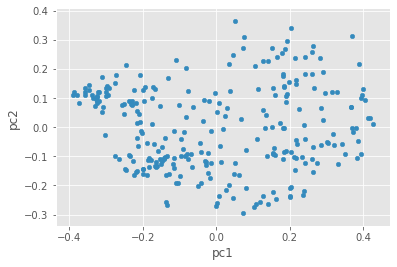

In [7]:
pca_df.plot.scatter(x='pc1', y='pc2')

Do you notice any clusters in the data? If you had to draw circles around 4 distinct groups of texts, how would you divide them?

Let's use the "color" column to see what `KMeans` did with this data:

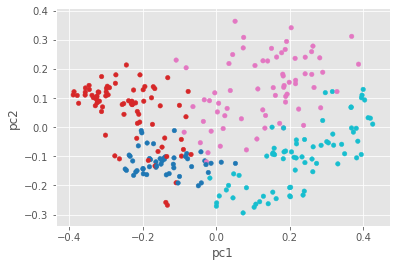

In [8]:
pca_df.plot.scatter(x='pc1', y='pc2', c='color', colormap='tab10', colorbar=False)

In the graph above, we can see how K-means divided our texts. We can't see all the variance using PCA, but this gives us a decent initial sense. We can see now why Group 2 (in red) isn't all that internally coherent---its texts aren't too close together. Some of the groups have closer, more "clustered" dots than others. So how did our unsupervised clustering method do? I think we might categorize this effort as *good* but not *great*. 

From looking at the way the dots are distributed mostly evenly across the graph, we can also see that this data might not be especially well suited for the K-means clustering approach. To get good results with K-means, you really want sets of dots that are already visibly "clustered" together on the graph. Though we got *decent enough* results with this approach, the visualization tells us that it's time to try something new.

The next question is: would the computer do a better job if we tried to teach it about the genres we already know? To answer that, we'll need a *supervised classification* method.